<h4>Classifying epileptic EEG signals</h4>

Epilepsy is a medical condition that affects around 50 million people globally according to the World Health Organization as of February 2024 (https://www.who.int/news-room/fact-sheets/detail/epilepsy). Here we will use There is evidence that suggests that the brain signal becomes alterated sometime before the seizure by the brain Here we will use a small sample of brain recordings to 

Handa, Palak, Monika Mathur, and Nidhi Goel. "Open and free EEG datasets for epilepsy diagnosis." arXiv preprint arXiv:2108.01030 (2021).

In [1]:
import pathlib

dataset_path = pathlib.Path('EEG-Epilepsy-Datasets')

with open(dataset_path / 'Datasets Information.txt', 'r') as description:
    text = description.read()
print(text)


Datasets:
These datasets are exemplary segmented EEG time series recordings of ten epilepsy patients collected from Neurology & Sleep Centre, Hauz Khas, New Delhi. The data was acquired at sampling rate of 200 Hz using Grass Telefactor Comet AS40 Amplification System. During the acquisition, gold plated scalp EEG electrodes were placed according to 10-20 electrode placement system. The signals were filtered between 0.5 to 70 Hz and then segmented into pre-ictal, interictal and ictal stages. Each downloadable folder contains fifty MAT-files of EEG time series signals. The name of the folder corresponds to the epileptic seizure stage. Each MAT-file consists of 1024 samples of one EEG time series data lasting for a duration of 5.12 seconds.     

Note: The datasets are part of an ongoing research work in collaboration of Neurocomputing Laboratory at IIT Delhi and Neurology & Sleep Centre, Hauz Khas. Kindly cite this link and following manuscript(s) when you publish results based the EEG s

# pre-requisites
- `conda install pytorch::pytorch`
https://anaconda.org/pytorch/pytorch

- `conda install anaconda::scipy`
https://anaconda.org/anaconda/scipy




In [19]:
from collections import defaultdict
from typing import Dict, List, Tuple

import scipy.io
import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


**Exercise 1** - Load the eeg data from the EEG-Epilepsy-Datasets folder. The data is organized in three subfolders: the first one contains EEG recordings from the ictal phase, the second one has EEG from the preictal phase and the last one has EEG from interictal (normal) brain state. Use the library pathlib to iterate over the files and load the EEGs

In [4]:
dataset_path = pathlib.Path('EEG-Epilepsy-Datasets')
eeg_signal_types = ['ictal', 'interictal', 'preictal']
eeg = defaultdict(list)
for eeg_type in eeg_signal_types:
    eeg_type_path = dataset_path / eeg_type
    for file in eeg_type_path.iterdir():
        eeg[eeg_type].append(scipy.io.loadmat(file))


In [ ]:
# Guillem's scipy.io.loadmat(file)[eeg_type]
# to avoid nested dict
# dataset_path = pathlib.Path('EEG-Epilepsy-Datasets')
# eeg_signal_types = ['ictal', 'interictal', 'preictal']
# eeg = defaultdict(list)
# for eeg_type in eeg_signal_types:
#     eeg_type_path = dataset_path / eeg_type
#     for file in eeg_type_path.iterdir():
#         eeg[eeg_type].append(scipy.io.loadmat(file)[eeg_type])


In [15]:
eeg.keys()


dict_keys(['ictal', 'interictal', 'preictal'])

In [5]:
eeg


defaultdict(list,
            {'ictal': [{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sat Aug 06 14:02:24 2016',
               '__version__': '1.0',
               '__globals__': [],
               'ictal': array([[113],
                      [208],
                      [289],
                      ...,
                      [ 83],
                      [ 76],
                      [ 79]], dtype=int16)},
              {'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sat Aug 06 14:02:24 2016',
               '__version__': '1.0',
               '__globals__': [],
               'ictal': array([[-305],
                      [-317],
                      [-328],
                      ...,
                      [ -92],
                      [ -73],
                      [ -47]], dtype=int16)},
              {'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sat Aug 06 14:02:24 2016',
               '__version__': '1.0',
      

We now have a dictionary with three keys: 'ictal', 'interictal' and 'preictal'. Each of the keys has an associated list value with all the recordings for that particular EEG state. Let's see how many recordings of each type we have:

In [6]:
print(len(eeg['ictal']))
print(len(eeg['interictal']))
print(len(eeg['preictal']))


50
50
50


Each recording has 1024 EEG datapoints that result from 5.12 seconds of measurement at a sampling rate of 200Hz. In addition to the EEG data, each .mat file that we loaded has a description of the recording:

In [36]:
eeg['ictal'][0]


{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sat Aug 06 14:02:24 2016',
 '__version__': '1.0',
 '__globals__': [],
 'ictal': array([[113],
        [208],
        [289],
        ...,
        [ 83],
        [ 76],
        [ 79]], dtype=int16)}

In [30]:
eeg['preictal']


[{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sat Aug 06 14:03:32 2016',
  '__version__': '1.0',
  '__globals__': [],
  'preictal': array([[20],
         [15],
         [ 8],
         ...,
         [71],
         [66],
         [57]], dtype=int16)},
 {'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sat Aug 06 14:03:32 2016',
  '__version__': '1.0',
  '__globals__': [],
  'preictal': array([[  5],
         [  8],
         [ 10],
         ...,
         [-55],
         [-54],
         [-46]], dtype=int16)},
 {'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sat Aug 06 14:03:32 2016',
  '__version__': '1.0',
  '__globals__': [],
  'preictal': array([[ 0],
         [ 0],
         [ 0],
         ...,
         [11],
         [10],
         [ 8]], dtype=int16)},
 {'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sat Aug 06 14:03:32 2016',
  '__version__': '1.0',
  '__globals__': [],
  'preictal': array([[ 7],
   

In [44]:
eeg['preictal'][0]['preictal']


array([[20],
       [15],
       [ 8],
       ...,
       [71],
       [66],
       [57]], dtype=int16)

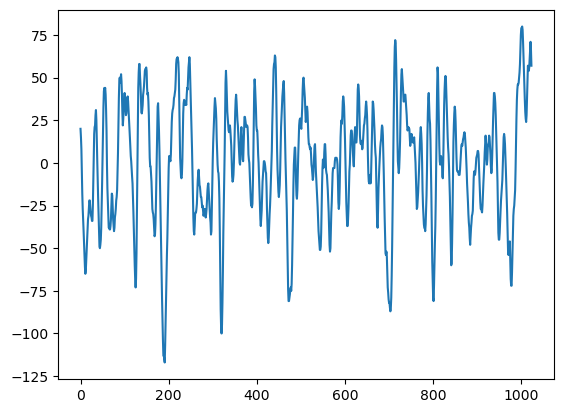

In [45]:
plt.plot(eeg['preictal'][0]['preictal'])


In [47]:
# NOTE
# NOTE modified eeg['ictal'][i]['ictal'] etc for extra level; not needed if leading matlab Guillem's way
training_set = []
for i in range(40):
    ictal_tensor = torch.tensor(eeg['ictal'][i]['ictal'], dtype=torch.float32).flatten()
    ictal_label = torch.tensor([0,0,1])
    interictal_tensor = torch.tensor(eeg['interictal'][i]['interictal'], dtype=torch.float32).flatten()
    interictal_label = torch.tensor([1,0,0])
    preictal_tensor = torch.tensor(eeg['preictal'][i]['preictal'], dtype=torch.float32).flatten()
    preictal_label = torch.tensor([0,1,0])
    training_set.append((ictal_tensor, ictal_label))
    training_set.append((interictal_tensor, interictal_label))
    training_set.append((preictal_tensor, preictal_label))


In [89]:
# NOTE
# NOTE modified eeg['ictal'][i]['ictal'] etc for extra level; not needed if leading matlab Guillem's way

test_set = []
for i in range(10):
    ictal_tensor = torch.tensor(eeg['ictal'][-i]['ictal'], dtype=torch.float32).flatten()
    ictal_label = torch.tensor([0,0,1])
    interictal_tensor = torch.tensor(eeg['interictal'][-i]['interictal'], dtype=torch.float32).flatten()
    interictal_label = torch.tensor([1,0,0])
    preictal_tensor = torch.tensor(eeg['preictal'][-i]['preictal'], dtype=torch.float32).flatten()
    preictal_label = torch.tensor([0,1,0])
    test_set.append((ictal_tensor, ictal_label))
    test_set.append((interictal_tensor, interictal_label))
    test_set.append((preictal_tensor, preictal_label))


In [50]:
np.random.shuffle(training_set)
np.random.shuffle(test_set)


In [51]:
training_set


[(tensor([ 4.,  5.,  8.,  ..., -8., -3.,  2.]), tensor([0, 1, 0])),
 (tensor([-78., -51.,  -7.,  ...,  42.,  49.,  48.]), tensor([0, 0, 1])),
 (tensor([6., 5., 5.,  ..., 1., 3., 2.]), tensor([0, 1, 0])),
 (tensor([50., 42., 36.,  ..., 28., 32., 33.]), tensor([1, 0, 0])),
 (tensor([-26., -26., -24.,  ..., -26., -30., -34.]), tensor([1, 0, 0])),
 (tensor([ 56.,  74.,  87.,  ..., 230., 282., 328.]), tensor([0, 0, 1])),
 (tensor([ 17.,  10.,   2.,  ..., -54., -54., -45.]), tensor([1, 0, 0])),
 (tensor([-14.,  -4.,   4.,  ...,  13.,  16.,  17.]), tensor([0, 1, 0])),
 (tensor([20., 15.,  8.,  ..., 71., 66., 57.]), tensor([0, 1, 0])),
 (tensor([ 35.,  33.,  40.,  ..., -17.,  10.,  33.]), tensor([0, 0, 1])),
 (tensor([ -9., -14., -18.,  ..., -24.,   1.,  24.]), tensor([0, 1, 0])),
 (tensor([ 30.,  33.,  30.,  ...,  -5.,  -3., -11.]), tensor([0, 1, 0])),
 (tensor([-44., -48., -49.,  ...,  29.,  10.,  13.]), tensor([0, 0, 1])),
 (tensor([-189., -209., -201.,  ..., -307., -281., -218.]), tensor([

In [53]:
test_set[0]


(tensor([10.,  7.,  2.,  ..., -2., -2., -2.]), tensor([1, 0, 0]))

**Exercise 2** From each The ictal state  The elements of the list should look as follows:

In [14]:
class EEGDataset(Dataset):
    def __init__(self, data: List[Tuple[Tensor, Tensor]]):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [54]:
training_set = EEGDataset(training_set)
test_set = EEGDataset(test_set)


In [55]:
trainloader = DataLoader(training_set, batch_size=16, shuffle=True)
testloader = DataLoader(test_set, batch_size=1)


In [66]:
for signal, label in trainloader:
    print(signal.shape, label.shape)
    break
    

torch.Size([16, 1024]) torch.Size([16, 3])


**Exercise 3** - Create a class called `NeuralNetwork` that inherits from `nn.Module` which will represent our model. In the `forward` method, 

In [21]:
os.path.join('EEG-Epilepsy-Datasets', 'ictal')


'EEG-Epilepsy-Datasets/ictal'

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__(self)
        # your code goes here

    def forward(self):
        # your code goes here
        pass


In [86]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # your code goes here
        self.linear_1 = nn.Linear(1024, 64)
        self.linear_2 = nn.Linear(64, 16)
        self.linear_3 = nn.Linear(16, 3)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)


    def forward(self, X):
        # your code goes here
        X = self.linear_1(X)  # or  X = self.sigmoid(self.linear_1(X))
        X = self.sigmoid(X)
        X = self.linear_2(X)
        X = self.sigmoid(X)
        X = self.linear_3(X)
        X = self.softmax(X)  # softmax instead of sigmoid for the last one
        return X


In [87]:
model = NeuralNetwork()


In [70]:
batch, labels = next(iter(trainloader))


In [71]:
batch.shape


torch.Size([16, 1024])

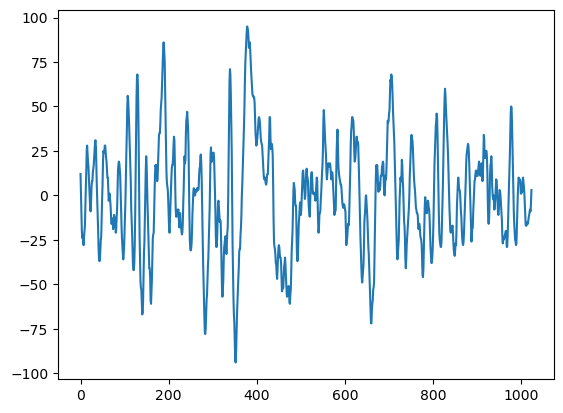

In [72]:
plt.plot(batch[0])


In [81]:
batch


tensor([[ 12.,   1., -10.,  ...,  -9.,  -4.,   3.],
        [ 57.,  45.,  37.,  ...,  44.,  31.,  20.],
        [ -4.,  -5.,  -4.,  ...,  28.,  26.,  22.],
        ...,
        [-35., -26., -17.,  ..., -12.,  -3.,   0.],
        [ 17.,  17.,  14.,  ...,  15.,  17.,  17.],
        [ 16.,  22.,  24.,  ...,   4.,   2.,   3.]])

In [82]:
model


NeuralNetwork(
  (linear_1): Linear(in_features=1024, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=16, bias=True)
  (linear_3): Linear(in_features=16, out_features=3, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)

In [85]:
dir(model)


['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_se

In [88]:
model(batch)


tensor([[0.3250, 0.3640, 0.3110],
        [0.3154, 0.3639, 0.3207],
        [0.3378, 0.3556, 0.3065],
        [0.3489, 0.3345, 0.3166],
        [0.3298, 0.3418, 0.3284],
        [0.3195, 0.3623, 0.3182],
        [0.3280, 0.3655, 0.3065],
        [0.3262, 0.3628, 0.3111],
        [0.3439, 0.3648, 0.2913],
        [0.3204, 0.3659, 0.3137],
        [0.3222, 0.3728, 0.3050],
        [0.3096, 0.3460, 0.3444],
        [0.3113, 0.3743, 0.3144],
        [0.3135, 0.3709, 0.3155],
        [0.3365, 0.3394, 0.3241],
        [0.3405, 0.3458, 0.3137]], grad_fn=<SoftmaxBackward0>)

**Exercise 5** - Define the training loop. 

<h4>References</h4>
[1] Handa, Palak, Monika Mathur, and Nidhi Goel. "Open and free EEG datasets for epilepsy diagnosis." arXiv preprint arXiv:2108.01030 (2021).

[2] Swami, Piyush, et al. "EEG epilepsy datasets." DOI: https://doi.org/10.13140/RG 2.14280.32006 (2016).